In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

import npc_lims
import npc_ephys
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import data_utils, spike_utils

from brainbox.metrics import single_units

# plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams.update({'font.size': 8,'pdf.fonttype':42})

%load_ext autoreload
%autoreload 2
%matplotlib widget

c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\one\alf\files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(


In [ ]:
# from brainbox.metrics import single_units

In [2]:
# load a session
session_id='668755_2023-08-30'

session = DynamicRoutingSession(session_id)
session_info=npc_lims.get_session_info(session.id)
# trials=data_utils.load_trials_or_units(session,'trials')
# units=data_utils.load_trials_or_units(session,'units')

# # print areas recorded
# units['structure'].unique()


In [3]:
si = npc_ephys.SpikeInterfaceKS25Data(session_info.id)

In [140]:
# si.quality_metrics_df(probe='A')
# amplitudes_path=si.get_correct_path(si.postprocessed(probe='A'),"spike_amplitudes","amplitude_segment_0.npy")

unit_index=si.unit_indexes(probe='A') #the unit INDEX of each spike
unique_unit_indices=np.unique(unit_index)
cluster_id=si.original_cluster_id(probe='A') #the original cluster id of each unit

# si.spike_indexes(probe='A') #the sample index of each spike?

In [17]:
amplitudes_path=r"D:\temp_session_data\amplitude_segment_0.npy"
amplitudes=np.load(amplitudes_path)
amplitudes

array([-189.54    , -182.51999 ,  -95.939995, ...,  -42.12    ,
        -70.2     , -163.79999 ], dtype=float32)

In [ ]:
sel_probe='probeA'
sel_unit_idx=0

sel_unit_amplitudes=amplitudes[unit_index==sel_unit_idx]
sel_unit_cluster_id=cluster_id[sel_unit_idx]

sel_unit=units.query('cluster_id==@sel_unit_cluster_id and electrode_group_name==@sel_probe')



,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,drift_ptp,drift_std,drift_mad,firing_range,firing_rate,isi_violations_ratio,...,location,peak_electrode,spike_times,obs_intervals,device_name,session_idx,date,subject_id,session_id,ibl_sliding_rp
id,,,,,,,,,,,,,,,,,,,,,
0,0.000142,0.409006,0.706314,65.52,8.172237,1.102786,1.472803,4.6,3.049501,0.055178,...,PIR,0,"[20.640432638777348, 20.652965944475646, 20.71...","[[20.230733542134328, 6516.0]]",18005114152,0,2023-08-30,668755,668755_2023-08-30_0,1


In [165]:
sel_unit_idx=0
sel_unit=units.iloc[sel_unit_idx]
sel_unit_cluster_id=sel_unit['cluster_id']
sel_unit_cluster_idx=np.where(cluster_id==sel_unit_cluster_id)[0][0]
sel_unit_amplitudes=amplitudes[unit_index==sel_unit_cluster_idx]

In [166]:
sel_unit_amplitudes

array([ -77.21999 ,  -84.24    ,  -95.939995, ..., -161.45999 ,
        -79.56    , -126.35999 ], dtype=float32)

In [ ]:
nc_pass, cutoff, first_low_quantile = single_units.noise_cutoff(sel_unit_amplitudes, quantile_length=.25, n_bins=100, nc_threshold=5, percent_threshold=0.10)

(True, 2.641902943484242, 5)

In [157]:
sel_unit

285

In [148]:
# units.query('cluster_id==@sel_unit_cluster_id and electrode_group_name==@sel_probe')

In [ ]:
#save units, trials, etc.
savepath=r"D:\temp_session_data"
units.to_pickle(os.path.join(savepath,str(session_id)+'_units.pkl'))
trials.to_pickle(os.path.join(savepath,str(session_id)+'_trials.pkl'))


In [23]:
#load units, trials
loadpath=r"D:\temp_session_data"
session_id='668755_2023-08-30'
units=pd.read_pickle(os.path.join(loadpath,str(session_id)+'_units.pkl'))
trials=pd.read_pickle(os.path.join(loadpath,str(session_id)+'_trials.pkl'))
# amplitudes=pd.read_pickle(os.path.join(loadpath,str(session_id)+'_amplitudes.pkl'))

In [127]:
units.query('electrode_group_name=="probeA"')['cluster_id'].unique().shape

(813,)

In [128]:
# units[['electrode_group_name','cluster_id']]
# units.columns

In [ ]:
sel_unit=units.iloc[0]
sel_unit

(1603,
 amplitude_cutoff                                                 0.000263
 amplitude_cv_median                                                   NaN
 amplitude_cv_range                                                    NaN
 amplitude_median                                                    128.7
 drift_ptp                                                       20.078735
 drift_std                                                        4.740824
 drift_mad                                                        4.914656
 firing_range                                                         13.8
 firing_rate                                                      4.440147
 isi_violations_ratio                                                  0.0
 isi_violations_count                                                  0.0
 num_spikes                                                        28844.0
 presence_ratio                                                   0.916667
 rp_contamination 

In [173]:
#compute ibl metrics

probe_units=units.query('electrode_group_name=="probeA"')

# ibl_contamination = []
# ibl_missed_spikes = []
unit_pass_sliding_rp=[]
unit_noise_cutoff=[]
unit_noise_cutoff_pass=[]
unit_noise_cutoff_first_low_quantile=[]

for uu,sel_unit in probe_units.iterrows():
    #sliding rp violation
    unit_pass_sliding_rp.append(single_units.slidingRP_viol(sel_unit['spike_times'], bin_size=0.25, thresh=0.1, acceptThresh=0.1))
    
    #single_units.noise_cutoff
    sel_unit_cluster_id=sel_unit['cluster_id']
    sel_unit_cluster_idx=np.where(cluster_id==sel_unit_cluster_id)[0][0]
    sel_unit_amplitudes=np.abs(amplitudes[unit_index==sel_unit_cluster_idx])

    nc_pass, cutoff, first_low_quantile = single_units.noise_cutoff(sel_unit_amplitudes, quantile_length=.25, n_bins=100, nc_threshold=5, percent_threshold=0.10)
    unit_noise_cutoff_pass.append(nc_pass)
    unit_noise_cutoff.append(cutoff)
    unit_noise_cutoff_first_low_quantile.append(first_low_quantile)

probe_units['ibl_sliding_rp']=unit_pass_sliding_rp
probe_units['ibl_noise_cutoff']=unit_noise_cutoff
probe_units['ibl_noise_cutoff_pass']=unit_noise_cutoff_pass
probe_units['ibl_noise_cutoff_first_low_quantile']=unit_noise_cutoff_first_low_quantile

#single_units.noise_cutoff
# single_units.noise_cutoff(amps, quantile_length=.25, n_bins=100, nc_threshold=5, percent_threshold=0.10)


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_29224\3123984380.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probe_units['ibl_sliding_rp']=unit_pass_sliding_rp
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_29224\3123984380.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  probe_units['ibl_noise_cutoff']=unit_noise_cutoff
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_29224\3123984380.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

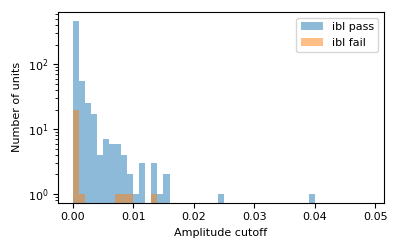

In [194]:
#plot noise cutoff pass/fail comp to amplitude cutoff
xbins=np.arange(0,0.05,0.001)
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['amplitude_cutoff'][probe_units['ibl_noise_cutoff_pass']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['amplitude_cutoff'][probe_units['ibl_noise_cutoff_pass']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
#set y logscale
ax.set_yscale('log')
ax.set_xlabel('Amplitude cutoff')
ax.set_ylabel('Number of units')
fig.tight_layout()

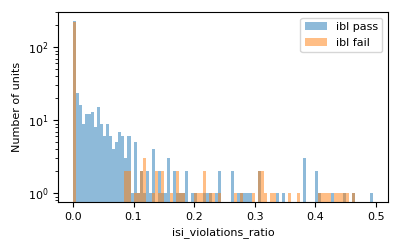

In [192]:
#plot sliding_rp pass/fail comp to isi_violations_ratio
xbins=np.arange(0,0.5,0.005)
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['isi_violations_ratio'][probe_units['ibl_sliding_rp']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['isi_violations_ratio'][probe_units['ibl_sliding_rp']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
# set y logscale
ax.set_yscale('log')
ax.set_xlabel('isi_violations_ratio')
ax.set_ylabel('Number of units')
fig.tight_layout()

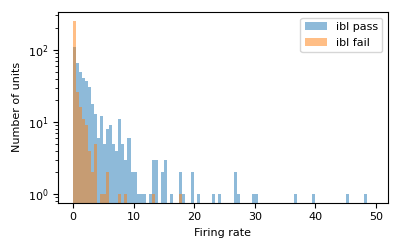

In [189]:
#plot distributions of firing rate according to ibl pass/fail
xbins=np.arange(0,50,0.5)

fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['firing_rate'][probe_units['ibl_sliding_rp']==1],bins=xbins,label='ibl pass',alpha=0.5)
ax.hist(probe_units['firing_rate'][probe_units['ibl_sliding_rp']==0],bins=xbins,label='ibl fail',alpha=0.5)
ax.legend()
# set y logscale
ax.set_yscale('log')
ax.set_xlabel('Firing rate')
ax.set_ylabel('Number of units')
fig.tight_layout()


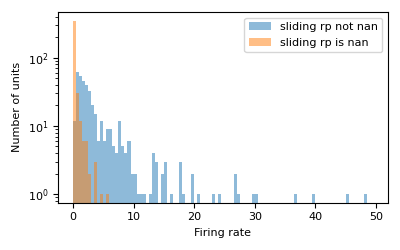

In [190]:
#plot distributions of firing rate according to ibl pass/fail
xbins=np.arange(0,50,0.5)

fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.hist(probe_units['firing_rate'][~np.isnan(probe_units['sliding_rp_violation'])],bins=xbins,label='sliding rp not nan',alpha=0.5)
ax.hist(probe_units['firing_rate'][np.isnan(probe_units['sliding_rp_violation'])],bins=xbins,label='sliding rp is nan',alpha=0.5)
ax.legend()
# set y logscale
ax.set_yscale('log')
ax.set_xlabel('Firing rate')
ax.set_ylabel('Number of units')
fig.tight_layout()


In [174]:
# # sel_unit_amplitudes
# n_bins=100
# bins_list = np.linspace(0, np.max(sel_unit_amplitudes), n_bins)  # list of bins to compute the amplitude histogram
# n, bins = np.histogram(sel_unit_amplitudes, bins=bins_list)

In [175]:
# bins_list

In [101]:
np.mean((units['ibl_sliding_rp']==1)==(units['sliding_rp_violation']<0.1))

0.7489114658925979

In [106]:
np.mean((units['ibl_sliding_rp']==1))

0.5910014513788099

In [105]:
# np.isnan(units['ibl_sliding_rp']).mean()
np.mean(units['ibl_sliding_rp'][np.isnan(units['sliding_rp_violation'])])

0.23514851485148514

In [6]:
num_violations

0

In [196]:
np.mean(units['isi_violations_ratio']<=0.1)

0.7317851959361393

In [46]:
np.mean(units['sliding_rp_violation']<=0.1)

0.3602322206095791

(array([429., 147.,  84.,  57.,  27.,  27.,  25.,  21.,  13.,   5.,   4.,
          6.,   4.,   7.,   4.,   5.,   2.,   2.,   1.,   0.,   2.,   2.,
          1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
        0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
        0.045, 0.046, 0.047, 0.048, 0.049]),
 <BarContainer object of 49 artists>)

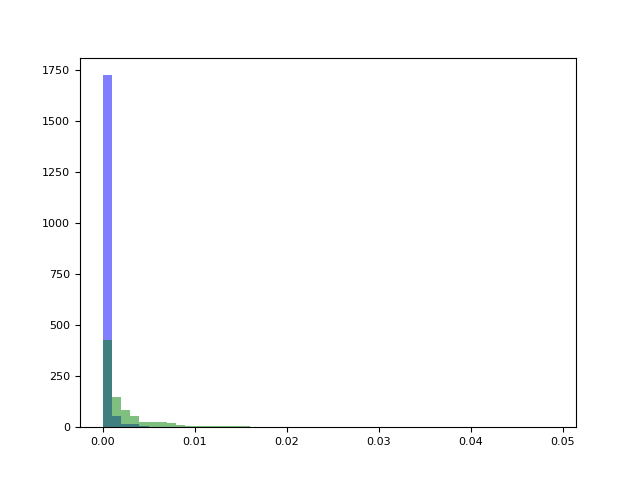

In [49]:
isnan_ind=np.isnan(units['sliding_rp_violation'])

# xbins=np.arange(0,0.4,0.01) #isi_viol
# xbins=np.arange(0,20,0.5) #fr
# xbins=np.arange(0,1.01,0.01) #presence_ratio
xbins=np.arange(0,0.05,0.001) #amplitude_cutoff

fig,ax=plt.subplots(1,1)
ax.hist(units['amplitude_cutoff'][~isnan_ind],bins=xbins,alpha=0.5,color='b')
ax.hist(units['amplitude_cutoff'][isnan_ind],bins=xbins,alpha=0.5,color='g')

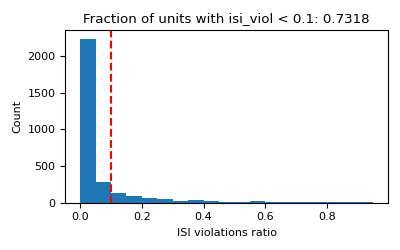

In [66]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))

xbins=np.arange(0,1,0.05) #amplitude

frac_below_10=np.mean(units['isi_violations_ratio']<0.1)

ax.axvline(0.1,linestyle='--',color='r')
ax.hist(units['isi_violations_ratio'],bins=xbins)
ax.set_title('Fraction of units with isi_viol < 0.1: '+str(np.round(frac_below_10,decimals=4)))
ax.set_xlabel('ISI violations ratio')
ax.set_ylabel('Count')
fig.tight_layout()

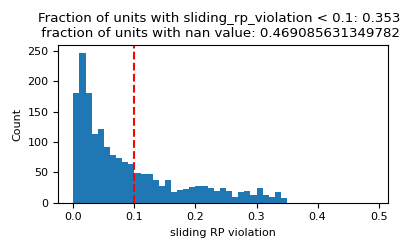

In [78]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))

xbins=np.arange(0,0.5,0.01) #amplitude

frac_below_10=np.mean(units['sliding_rp_violation']<0.1)

ax.axvline(0.1,linestyle='--',color='r')
ax.hist(units['sliding_rp_violation'],bins=xbins)
ax.set_title('Fraction of units with sliding_rp_violation < 0.1: '+str(np.round(frac_below_10,decimals=4))+
             '\n fraction of units with nan value: '+str(np.mean(np.isnan(units['sliding_rp_violation']))))
ax.set_xlabel('sliding RP violation')
ax.set_ylabel('Count')
fig.tight_layout()

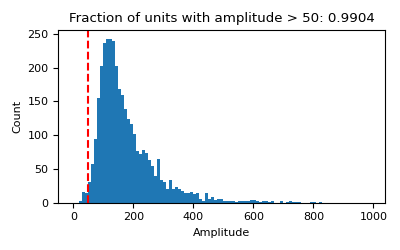

In [67]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))

xbins=np.arange(0,1000,10) #amplitude

frac_above_50=np.mean(units['amplitude']>50)

ax.axvline(50,linestyle='--',color='r')
ax.hist(units['amplitude'],bins=xbins)
ax.set_title('Fraction of units with amplitude > 50: '+str(np.round(frac_above_50,decimals=4)))
ax.set_xlabel('Amplitude')
ax.set_ylabel('Count')
fig.tight_layout()

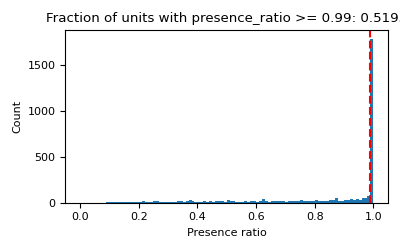

In [83]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))

xbins=np.arange(0,1.01,0.01) #amplitude

frac_above_99=np.mean(units['presence_ratio']>=0.99)

ax.axvline(0.99,linestyle='--',color='r')
ax.hist(units['presence_ratio'],bins=xbins)
ax.set_title('Fraction of units with presence_ratio >= 0.99: '+str(np.round(frac_above_99,decimals=4)))
ax.set_xlabel('Presence ratio')
ax.set_ylabel('Count')
fig.tight_layout()

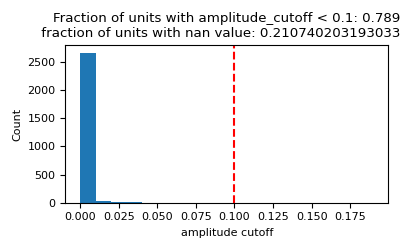

In [85]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))

xbins=np.arange(0,0.2,0.01) #amplitude

frac_below_01=np.mean(units['amplitude_cutoff']<0.1)

ax.axvline(0.1,linestyle='--',color='r')
ax.hist(units['amplitude_cutoff'],bins=xbins)
ax.set_title('Fraction of units with amplitude_cutoff < 0.1: '+str(np.round(frac_below_01,decimals=4))+
             '\n fraction of units with nan value: '+str(np.mean(np.isnan(units['amplitude_cutoff']))))
ax.set_xlabel('amplitude cutoff')
ax.set_ylabel('Count')
fig.tight_layout()

In [ ]:
fig,ax=plt.subplots(1,1)

In [35]:
units['sliding_rp_violation'][isnan_ind]

id
1610   NaN
1617   NaN
1618   NaN
1621   NaN
1654   NaN
        ..
1010   NaN
400    NaN
399    NaN
987    NaN
1190   NaN
Name: sliding_rp_violation, Length: 1616, dtype: float64